In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import Flatten, Dense, Dropout, MaxPool2D, Conv2D
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input

2024-02-21 00:52:55.503370: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 00:52:55.503478: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 00:52:55.631899: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_dir = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train'
test_dir = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test'

train_ds = tf.keras.utils.image_dataset_from_directory(train_dir, labels='inferred', image_size=(32,32))
test_ds = tf.keras.utils.image_dataset_from_directory(test_dir, labels='inferred', image_size=(32,32))

Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.


# Image Examples
Here we display a group of various images from our dataset to get an idea for the input of our CNN

['FAKE', 'REAL']


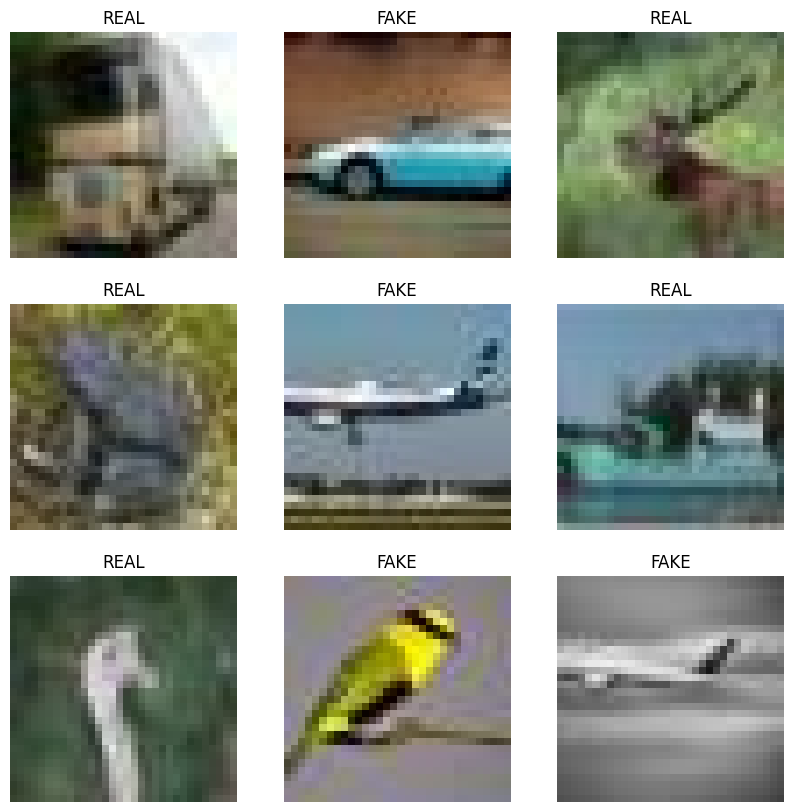

In [3]:
label_names = test_ds.class_names
print(label_names)
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(label_names[labels[i]])
        plt.axis("off")

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Image Size
As we use the modified dataset provided from the research, the input images have already been scaled down and normalized, into a shape of 32 by 32 pixels

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print('Original image shape: ', mpimg.imread('/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test/FAKE/0 (10).jpg').shape)
datagen = ImageDataGenerator(rescale=1/255.0)

train_data = datagen.flow_from_directory(train_dir, target_size=(32,32), class_mode='binary')
test_data = datagen.flow_from_directory(test_dir, target_size=(32,32), class_mode='binary')
train_data.dtype

Original image shape:  (32, 32, 3)
Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


'float32'

# Model Architecture
Throughout expermintation, multiple different architectures were tested to determine the ideal hyperparamaters to accurately identify real images. By varying the amount of filters, layers, and dense nuerons, 36 different models were tested. This model represents the final design, which utilized 2 layers with 32 filters, and only a single dense layer of 64 nuerons. The final layer is the output layer, which uses sigmoid activation to map the output to a value between 0 and 1, which is used as our confidence that the image is real or fake. 

In [6]:
model = Sequential()
model.add(Conv2D(32, (3, 3), strides=1, padding="same", activation="relu", input_shape=(32, 32, 3)))
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(32, (3, 3), strides=1, padding="same", activation="relu"))
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=64, activation="relu"))
model.add(Dense(units=1, activation="sigmoid")) #uses sigmoid activation, with output shape of 1

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 64)                1

# Loss Function
We use binary cross entropy

In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'])

In [9]:
model.fit(train_ds, validation_data=test_ds, epochs=10)

Epoch 1/10


I0000 00:00:1708476893.734456      79 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3125/3125 [==============================] - 100s 31ms/step - loss: 1.7212 - accuracy: 0.7043 - val_loss: 1.0643 - val_accuracy: 0.7543
Epoch 2/10
3125/3125 [==============================] - 12s 4ms/step - loss: 0.9204 - accuracy: 0.7766 - val_loss: 0.8018 - val_accuracy: 0.7881
Epoch 3/10
3125/3125 [==============================] - 12s 4ms/step - loss: 0.7331 - accuracy: 0.8009 - val_loss: 0.6837 - val_accuracy: 0.8048
Epoch 4/10
3125/3125 [==============================] - 12s 4ms/step - loss: 0.6205 - accuracy: 0.8155 - val_loss: 0.5969 - val_accuracy: 0.8176
Epoch 5/10
3125/3125 [==============================] - 12s 4ms/step - loss: 0.5395 - accuracy: 0.8286 - val_loss: 0.5413 - val_accuracy: 0.8295
Epoch 6/10
3125/3125 [==============================] - 12s 4ms/step - loss: 0.4808 - accuracy: 0.8398 - val_loss: 0.4927 - val_accuracy: 0.8375
Epoch 7/10
3125/3125 [==============================] - 12s 4ms/step - loss: 0.4363 - accuracy: 0.8482 - val_loss: 0.4611 - val_accuracy: 0

In [10]:
model.save_weights('./checkpoints/final') #comment after use

In [11]:
model.load_weights('./checkpoints/final')
loss, acc = model.evaluate(test_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

625/625 - 1s - loss: 0.3966 - accuracy: 0.8546 - 1s/epoch - 2ms/step
Restored model, accuracy: 85.46%


In [12]:
def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

def make_predictions(image_path):
    show_image(image_path)
    image = image_utils.load_img(image_path, target_size=(32, 32))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,32,32,3)
    image = preprocess_input(image)
    image = image / 255.0
    preds = model.predict(image)
    pred_bool = np.round(preds)
    if(pred_bool > 0.5):
        return 'Fake'
    return 'Real'

1/1 [==============================] - 0s 251ms/step
Real


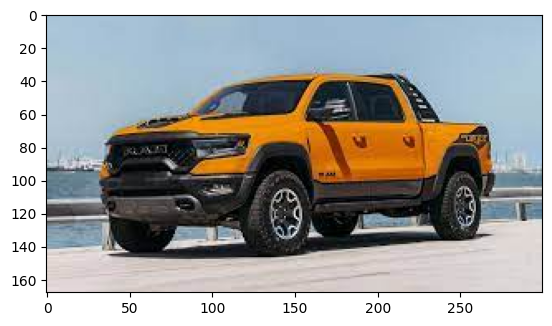

In [13]:
print(make_predictions('/kaggle/input/truckimage/truck.jpg'))

1/1 [==============================] - 0s 18ms/step


'Fake'

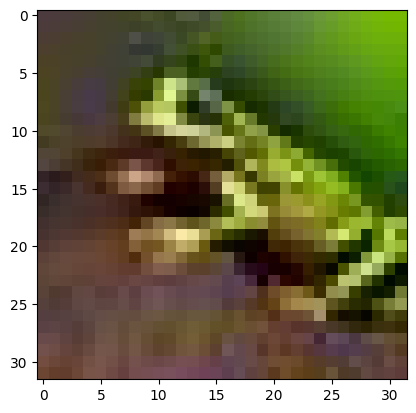

In [14]:
make_predictions('/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test/FAKE/0 (7).jpg')

1/1 [==============================] - 0s 18ms/step


'Real'

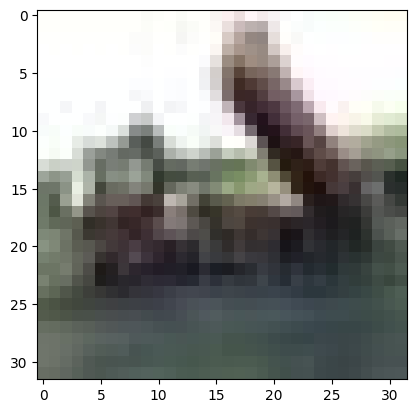

In [15]:
make_predictions('/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train/REAL/0001 (10).jpg')